In [ ]:
# Install once before starting.
!pip install -U keras

In [ ]:
import os

# Use Either one of these as backend.
# os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["KERAS_BACKEND"] = "torch"

# There's some internal with JAX backend with keras3 right now,
# we'll update it as soon as there's any development.
# os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
from dataclasses import dataclass
from typing import Union, Optional

import cv2
import numpy as np
import matplotlib.pyplot as plt

import keras
import keras.ops as kops
from keras import Model, Input
from keras.layers import (
    Layer,
    Conv2D,
    DepthwiseConv2D,
    BatchNormalization,
    Activation,
    Dense,
    Dropout,
    Softmax,
    GlobalAveragePooling2D,
    LayerNormalization,
    Add,
    Identity,
    Concatenate,
    ZeroPadding2D,
)

# Basic utils

In [ ]:
# https://www.tensorflow.org/guide/mixed_precision#ensuring_gpu_tensor_cores_are_used
def make_divisible(v: Union[int, float], divisor: Optional[Union[int, float]] = 8, min_value: Optional[Union[int, float]] = None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

# Base Layers

In [ ]:
class ConvLayer(Layer):
    def __init__(
        self,
        num_filters: int = 16,
        kernel_size: int = 3,
        strides: int = 2,
        use_activation: bool = True,
        use_bn: bool = True,
        use_bias: bool = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.use_bn = use_bn
        self.use_activation = use_activation
        self.use_bias = use_bias if use_bias is not None else (False if self.use_bn else True)

        if self.strides == 2:
            self.zero_pad = ZeroPadding2D(padding=(1, 1))
            conv_padding = "valid"
        else:
            self.zero_pad = Identity()
            conv_padding = "same"
        self.conv = Conv2D(filters=self.num_filters, kernel_size=self.kernel_size, strides=self.strides, padding=conv_padding, use_bias=self.use_bias)

        if self.use_bn:
            self.bn = BatchNormalization(epsilon=1e-05, momentum=0.1)

        if self.use_activation:
            self.activation = Activation("swish")

    def call(self, x, **kwargs):
        x = self.zero_pad(x)
        x = self.conv(x)
        if self.use_bn:
            x = self.bn(x)

        if self.use_activation:
            x = self.activation(x)

        return x

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "num_filters": self.num_filters,
                "kernel_size": self.kernel_size,
                "strides": self.strides,
                "use_bias": self.use_bias,
                "use_activation": self.use_activation,
                "use_bn": self.use_bn,
            }
        )
        return config


class InvertedResidualBlock(Layer):
    def __init__(
        self,
        in_channels: int = 32,
        out_channels: int = 64,
        depthwise_stride: int = 1,
        expansion_factor: Union[int, float] = 2,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # Input Parameters

        self.num_in_channels = in_channels
        self.out_channels = out_channels
        self.depthwise_stride = depthwise_stride
        self.expansion_factor = expansion_factor

        num_out_channels = int(make_divisible(self.out_channels, divisor=8))
        expansion_channels = int(make_divisible(self.expansion_factor * self.num_in_channels))

        # Layer Attributes
        apply_expansion = expansion_channels > self.num_in_channels
        self.residual_connection = True if (self.num_in_channels == num_out_channels) and (self.depthwise_stride == 1) else False

        # Layers
        if apply_expansion:
            self.expansion_conv_block = ConvLayer(num_filters=expansion_channels, kernel_size=1, strides=1, use_activation=True, use_bn=True)
        else:
            self.expansion_conv_block = Identity()

        self.depthwise_conv_zero_pad = ZeroPadding2D(padding=(1, 1))
        self.depthwise_conv = DepthwiseConv2D(kernel_size=3, strides=self.depthwise_stride, padding="valid", use_bias=False)
        self.bn = BatchNormalization(epsilon=1e-05, momentum=0.1)
        self.activation = Activation("swish")
        self.out_conv_block = ConvLayer(num_filters=num_out_channels, kernel_size=1, strides=1, use_activation=False, use_bn=True)

    def call(self, data, **kwargs):
        out = self.expansion_conv_block(data)
        out = self.depthwise_conv_zero_pad(out)
        out = self.depthwise_conv(out)
        out = self.bn(out)
        out = self.activation(out)
        out = self.out_conv_block(out)

        if self.residual_connection:
            return out + data

        return out

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "in_channels": self.num_in_channels,
                "out_channels": self.out_channels,
                "depthwise_stride": self.depthwise_stride,
                "expansion_factor": self.expansion_factor,
            }
        )
        return config

# Multi-Head Self Attention

In [ ]:
class MHSA(Layer):
    def __init__(
        self,
        num_heads: int = 2,
        embedding_dim: int = 64,
        projection_dim: int = None,
        qkv_bias: bool = True,
        attention_drop: float = 0.2,
        linear_drop: float = 0.2,
    ):
        super().__init__()
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.projection_dim = projection_dim if projection_dim else embedding_dim // num_heads
        self.qkv_bias = qkv_bias
        self.scale = self.projection_dim**-0.5

        self.qkv = Dense(3 * self.num_heads * self.projection_dim, use_bias=qkv_bias)
        self.proj = Dense(embedding_dim, use_bias=qkv_bias)
        self.attn_dropout = Dropout(attention_drop)
        self.linear_dropout = Dropout(linear_drop)
        self.softmax = Softmax()

    def build(self, input_shape):
        # You can perform setup tasks that depend on the input shape here
        super().build(input_shape)

    def split_heads(self, x, batch_size):
        # Split the last dimension into (num_heads, projection_dim)
        x = kops.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        # Transpose to shape (batch_size, num_heads, seq_len, projection_dim)
        return kops.transpose(x, axes=(0, 2, 1, 3))

    def call(self, x):
        batch_size = kops.shape(x)[0]

        # Project and reshape to (batch_size, seq_len, 3, num_heads, projection_dim)
        qkv = self.qkv(x)
        qkv = kops.reshape(qkv, (batch_size, -1, 3, self.num_heads, self.projection_dim))
        qkv = kops.transpose(qkv, axes=(0, 2, 1, 3, 4))
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        q *= self.scale

        # Attention mechanism
        attn_logits = kops.matmul(q, kops.transpose(k, axes=(0, 1, 3, 2)))
        attn = self.softmax(attn_logits)
        attn = self.attn_dropout(attn)

        weighted_avg = kops.matmul(attn, v)
        weighted_avg = kops.transpose(weighted_avg, axes=(0, 2, 1, 3))
        weighted_avg = kops.reshape(weighted_avg, (batch_size, -1, self.num_heads * self.projection_dim))

        # Output projection
        output = self.proj(weighted_avg)
        output = self.linear_dropout(output)

        return output

# MobileVIT-Block

In [ ]:
class Transformer(Layer):
    def __init__(
        self,
        num_heads: int = 4,
        embedding_dim: int = 90,
        qkv_bias: bool = True,
        mlp_ratio: float = 2.0,
        dropout: float = 0.1,
        linear_drop: float = 0.0,
        attention_drop: float = 0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.embedding_dim = embedding_dim
        self.qkv_bias = qkv_bias
        self.mlp_ratio = mlp_ratio
        self.dropout = dropout
        self.linear_drop = linear_drop
        self.attention_drop = attention_drop

        self.norm_1 = LayerNormalization(epsilon=1e-5)

        self.attn = MHSA(
            num_heads=self.num_heads,
            embedding_dim=self.embedding_dim,
            qkv_bias=self.qkv_bias,
            attention_drop=self.attention_drop,
            linear_drop=dropout,
        )
        self.norm_2 = LayerNormalization(epsilon=1e-5)

        hidden_features = int(self.embedding_dim * self.mlp_ratio)

        self.mlp_block_0 = Dense(hidden_features, activation="swish")
        self.mlp_block_1 = Dropout(self.linear_drop)
        self.mlp_block_2 = Dense(embedding_dim)
        self.mlp_block_3 = Dropout(dropout)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, x):
        x = x + self.attn(self.norm_1(x))

        mlp_block_out = self.mlp_block_0(self.norm_2(x))
        mlp_block_out = self.mlp_block_1(mlp_block_out)
        mlp_block_out = self.mlp_block_2(mlp_block_out)
        mlp_block_out = self.mlp_block_3(mlp_block_out)

        x = x + mlp_block_out

        return x

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "embedding_dim": self.embedding_dim,
                "qkv_bias": self.qkv_bias,
                "mlp_ratio": self.mlp_ratio,
                "dropout": self.dropout,
                "linear_drop": self.linear_drop,
                "attention_drop": self.attention_drop,
            }
        )
        return config

class MobileViT_v1_Block(Layer):
    def __init__(
        self,
        out_filters: int = 64,
        embedding_dim: int = 90,
        patch_size: Union[int, tuple] = 2,
        transformer_repeats: int = 2,
        num_heads: int = 4,
        dropout: float = 0.1,
        attention_drop: float = 0.0,
        linear_drop: float = 0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.out_filters = out_filters
        self.embedding_dim = embedding_dim
        self.patch_size = patch_size
        self.transformer_repeats = transformer_repeats
        self.num_heads = num_heads
        self.dropout = dropout
        self.attention_drop = attention_drop
        self.linear_drop = linear_drop

        self.patch_size_h, self.patch_size_w = patch_size if isinstance(self.patch_size, tuple) else (self.patch_size, self.patch_size)
        self.patch_size_h, self.patch_size_w = kops.cast(self.patch_size_h, dtype="int32"), kops.cast(self.patch_size_w, dtype="int32")

        # # local_feature_extractor 1 and 2
        self.local_rep_layer_1 = ConvLayer(num_filters=self.out_filters, kernel_size=3, strides=1, use_bn=True, use_activation=True)
        self.local_rep_layer_2 = ConvLayer(num_filters=self.embedding_dim, kernel_size=1, strides=1, use_bn=False, use_activation=False, use_bias=False)

        self.transformer_layers = [
            Transformer(
                embedding_dim=self.embedding_dim,
                num_heads=self.num_heads,
                dropout=self.dropout,
                attention_drop=self.attention_drop,
                linear_drop=self.linear_drop,
            )
            for _ in range(self.transformer_repeats)
        ]

        self.transformer_layer_norm = LayerNormalization(epsilon=1e-5)

        # Fusion blocks
        self.local_features_3 = ConvLayer(num_filters=self.out_filters, kernel_size=1, strides=1, use_bn=True, use_activation=True)
        self.concat = Concatenate(axis=-1)
        self.fuse_local_global = ConvLayer(num_filters=self.out_filters, kernel_size=3, strides=1, use_bn=True, use_activation=True)

    def build(self, input_shape):
        super().build(input_shape)

    def call(self, x):

        fmH, fmW = kops.shape(x)[1], kops.shape(x)[2]

        local_representation = self.local_rep_layer_1(x)
        local_representation = self.local_rep_layer_2(local_representation)
        out_channels = local_representation.shape[-1]

        # Transformer as Convolution Steps
        # --------------------------------
        # # Unfolding

        unfolded, info_dict = self.unfolding(local_representation)

        # # Infomation sharing/mixing --> global representation
        for layer in self.transformer_layers:
            unfolded = layer(unfolded)

        global_representation = self.transformer_layer_norm(unfolded)

        # #Folding
        folded = self.folding(global_representation, info_dict=info_dict, outH=fmH, outW=fmW, outC=out_channels)

        # Fusion
        local_mix = self.local_features_3(folded)
        fusion = self.concat([x, local_mix])
        fusion = self.fuse_local_global(fusion)

        return fusion

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "out_filters": self.out_filters,
                "embedding_dim": self.embedding_dim,
                "patch_size": self.patch_size,
                "transformer_repeats": self.transformer_repeats,
                "num_heads": self.num_heads,
                "dropout": self.dropout,
                "attention_drop": self.attention_drop,
                "linear_drop": self.linear_drop,
            }
        )
        return config

    def unfolding(self, feature_map):
        # Initially convert channel-last to channel-first for processing
        shape = kops.shape(feature_map)
        batch_size, orig_h, orig_w, in_channels = shape[0], shape[1], shape[2], shape[3]
        feature_map = kops.transpose(feature_map, [0, 3, 1, 2])  # [B, H, W, C] -> [B, C, H, W]

        patch_area = self.patch_size_w * self.patch_size_h

        orig_h, orig_w = kops.cast(orig_h, dtype="int32"), kops.cast(orig_w, dtype="int32")

        h_ceil = kops.ceil(orig_h / self.patch_size_h)
        w_ceil = kops.ceil(orig_w / self.patch_size_w)

        new_h = kops.cast(h_ceil * kops.cast(self.patch_size_h, dtype=h_ceil.dtype), dtype="int32")
        new_w = kops.cast(w_ceil * kops.cast(self.patch_size_w, dtype=h_ceil.dtype), dtype="int32")

        # Condition to decide if resizing is necessary
        resize_required = kops.logical_or(kops.not_equal(new_w, orig_w), kops.not_equal(new_h, orig_h))
        feature_map = kops.cond(
            resize_required,
            true_fn=lambda: kops.image.resize(feature_map, [new_h, new_w], data_format="channels_first"),
            false_fn=lambda: feature_map,
        )

        num_patch_h = new_h // self.patch_size_h
        num_patch_w = new_w // self.patch_size_w
        num_patches = num_patch_h * num_patch_w

        # Handle dynamic shape multiplication
        dynamic_shape_mul = kops.prod([batch_size, in_channels * num_patch_h])

        # Reshape and transpose to create patches
        reshaped_fm = kops.reshape(feature_map, [dynamic_shape_mul, self.patch_size_h, num_patch_w, self.patch_size_w])
        transposed_fm = kops.transpose(reshaped_fm, [0, 2, 1, 3])
        reshaped_fm = kops.reshape(transposed_fm, [batch_size, in_channels, num_patches, patch_area])
        transposed_fm = kops.transpose(reshaped_fm, [0, 3, 2, 1])
        patches = kops.reshape(transposed_fm, [batch_size * patch_area, num_patches, in_channels])

        info_dict = {
            "orig_size": (orig_h, orig_w),
            "batch_size": batch_size,
            "interpolate": resize_required,
            "total_patches": num_patches,
            "num_patches_w": num_patch_w,
            "num_patches_h": num_patch_h,
            "patch_area": patch_area,
        }

        return patches, info_dict

    def folding(self, patches, info_dict, outH, outW, outC):
        # Ensure the input patches tensor has the correct dimensions
        assert len(patches.shape) == 3, f"Tensor should be of shape BPxNxC. Got: {patches.shape}"

        # Reshape to [B, P, N, C]
        patches = kops.reshape(patches, [info_dict["batch_size"], info_dict["patch_area"], info_dict["total_patches"], -1])

        # Get shape parameters for further processing
        shape = kops.shape(patches)
        batch_size = shape[0]
        channels = shape[3]

        num_patch_h = info_dict["num_patches_h"]
        num_patch_w = info_dict["num_patches_w"]

        # Transpose dimensions [B, P, N, C] --> [B, C, N, P]
        patches = kops.transpose(patches, [0, 3, 2, 1])

        # Calculate total elements dynamically
        num_total_elements = batch_size * channels * num_patch_h

        # Reshape to match the size of the feature map before splitting into patches
        # [B, C, N, P] --> [B*C*n_h, n_w, p_h, p_w]
        feature_map = kops.reshape(patches, [num_total_elements, num_patch_w, self.patch_size_h, self.patch_size_w])

        # Transpose to switch width and height axes [B*C*n_h, n_w, p_h, p_w] --> [B*C*n_h, p_h, n_w, p_w]
        feature_map = kops.transpose(feature_map, [0, 2, 1, 3])

        # Reshape back to the original image dimensions [B*C*n_h, p_h, n_w, p_w] --> [B, C, H, W]
        # Reshape back to [B, C, H, W]
        new_height = num_patch_h * self.patch_size_h
        new_width = num_patch_w * self.patch_size_w
        feature_map = kops.reshape(feature_map, [batch_size, -1, new_height, new_width])

        # Conditional resizing using kops.cond
        feature_map = kops.cond(
            info_dict["interpolate"],
            lambda: kops.image.resize(feature_map, info_dict["orig_size"], data_format="channels_first"),
            lambda: feature_map,
        )

        feature_map = kops.transpose(feature_map, [0, 2, 3, 1])
        feature_map = kops.reshape(feature_map, (batch_size, outH, outW, outC))

        return feature_map

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# MobileVIT Model Architecture

In [ ]:
def MobileViT_v1(
    configs,
    dropout: float = 0.1,
    linear_drop: float = 0.0,
    attention_drop: float = 0.0,
    num_classes: int | None = 1000,
    input_shape: tuple[int, int, int] = (256, 256, 3),
    model_name: str = f"MobileViT_v1-S",
):
    """
    Arguments
    --------

        configs: A dataclass instance with model information such as per layer output channels, transformer embedding dimensions, transformer repeats, IR expansion factor

        num_classes: (int)   Number of output classes

        input_shape: (tuple) Input shape -> H, W, C

        model_type: (str)   Model to create

        linear_drop: (float) Dropout rate for Dense layers

        attention_drop: (float) Dropout rate for the attention matrix

    """

    input_layer = Input(shape=input_shape)

    # Block 1
    out = ConvLayer(
        num_filters=configs.block_1_1_dims,
        kernel_size=3,
        strides=2,
        name="block-1-Conv",
    )(input_layer)

    out = InvertedResidualBlock(
        in_channels=configs.block_1_1_dims,
        out_channels=configs.block_1_2_dims,
        depthwise_stride=1,
        expansion_factor=configs.depthwise_expansion_factor,
        name="block-1-IR2",
    )(out)

    # Block 2
    out = InvertedResidualBlock(
        in_channels=configs.block_1_2_dims,
        out_channels=configs.block_2_1_dims,
        depthwise_stride=2,
        expansion_factor=configs.depthwise_expansion_factor,
        name="block-2-IR1",
    )(out)

    out = InvertedResidualBlock(
        in_channels=configs.block_2_1_dims,
        out_channels=configs.block_2_2_dims,
        depthwise_stride=1,
        expansion_factor=configs.depthwise_expansion_factor,
        name="block-2-IR2",
    )(out)

    out = InvertedResidualBlock(
        in_channels=configs.block_2_2_dims,
        out_channels=configs.block_2_3_dims,
        depthwise_stride=1,
        expansion_factor=configs.depthwise_expansion_factor,
        name="block-2-IR3",
    )(out)

    # Block 3
    out = InvertedResidualBlock(
        in_channels=configs.block_2_2_dims,
        out_channels=configs.block_3_1_dims,
        depthwise_stride=2,
        expansion_factor=configs.depthwise_expansion_factor,
        name="block-3-IR1",
    )(out)

    out = MobileViT_v1_Block(
        out_filters=configs.block_3_2_dims,
        embedding_dim=configs.tf_block_3_dims,
        transformer_repeats=configs.tf_block_3_repeats,
        name="MobileViTBlock-1",
        dropout=dropout,
        attention_drop=attention_drop,
        linear_drop=linear_drop,
    )(out)

    # Block 4
    out = InvertedResidualBlock(
        in_channels=configs.block_3_2_dims,
        out_channels=configs.block_4_1_dims,
        depthwise_stride=2,
        expansion_factor=configs.depthwise_expansion_factor,
        name="block-4-IR1",
    )(out)

    out = MobileViT_v1_Block(
        out_filters=configs.block_4_2_dims,
        embedding_dim=configs.tf_block_4_dims,
        transformer_repeats=configs.tf_block_4_repeats,
        name="MobileViTBlock-2",
        dropout=dropout,
        attention_drop=attention_drop,
        linear_drop=linear_drop,
    )(out)

    # Block 5
    out = InvertedResidualBlock(
        in_channels=configs.block_4_2_dims,
        out_channels=configs.block_5_1_dims,
        depthwise_stride=2,
        expansion_factor=configs.depthwise_expansion_factor,
        name="block-5-IR1",
    )(out)

    out = MobileViT_v1_Block(
        out_filters=configs.block_5_2_dims,
        embedding_dim=configs.tf_block_5_dims,
        transformer_repeats=configs.tf_block_5_repeats,
        name="MobileViTBlock-3",
        dropout=dropout,
        attention_drop=attention_drop,
        linear_drop=linear_drop,
    )(out)

    out = ConvLayer(num_filters=configs.final_conv_dims, kernel_size=1, strides=1, name="final_conv")(out)

    if num_classes:
        # Output layer
        out = GlobalAveragePooling2D()(out)

        if linear_drop > 0.0:
            out = Dropout(rate=dropout)(out)

        out = Dense(units=num_classes)(out)

    model = Model(inputs=input_layer, outputs=out, name=model_name)

    return model

# Configs

In [ ]:
@dataclass
class Config_MobileViT_v1_S:
    block_1_1_dims: int = 16
    block_1_2_dims: int = 32

    block_2_1_dims: int = 64
    block_2_2_dims: int = 64
    block_2_3_dims: int = 64

    block_3_1_dims: int = 96
    block_3_2_dims: int = 96

    block_4_1_dims: int = 128
    block_4_2_dims: int = 128

    block_5_1_dims: int = 160
    block_5_2_dims: int = 160

    final_conv_dims: int = 640

    tf_block_3_dims: int = 144
    tf_block_4_dims: int = 192
    tf_block_5_dims: int = 240

    tf_block_3_repeats: int = 2
    tf_block_4_repeats: int = 4
    tf_block_5_repeats: int = 3

    depthwise_expansion_factor: int = 4


@dataclass
class Config_MobileViT_v1_XS:
    block_1_1_dims: int = 16
    block_1_2_dims: int = 32

    block_2_1_dims: int = 48
    block_2_2_dims: int = 48
    block_2_3_dims: int = 48

    block_3_1_dims: int = 64
    block_3_2_dims: int = 64

    block_4_1_dims: int = 80
    block_4_2_dims: int = 80

    block_5_1_dims: int = 96
    block_5_2_dims: int = 96

    final_conv_dims: int = 384

    tf_block_3_dims: int = 96
    tf_block_4_dims: int = 120
    tf_block_5_dims: int = 144

    tf_block_3_repeats: int = 2
    tf_block_4_repeats: int = 4
    tf_block_5_repeats: int = 3

    depthwise_expansion_factor: int = 4


@dataclass
class Config_MobileViT_v1_XXS:
    block_1_1_dims: int = 16
    block_1_2_dims: int = 16

    block_2_1_dims: int = 24
    block_2_2_dims: int = 24
    block_2_3_dims: int = 24

    block_3_1_dims: int = 48
    block_3_2_dims: int = 48

    block_4_1_dims: int = 64
    block_4_2_dims: int = 64

    block_5_1_dims: int = 80
    block_5_2_dims: int = 80

    final_conv_dims: int = 320

    tf_block_3_dims: int = 64
    tf_block_4_dims: int = 80
    tf_block_5_dims: int = 96

    tf_block_3_repeats: int = 2
    tf_block_4_repeats: int = 4
    tf_block_5_repeats: int = 3

    depthwise_expansion_factor: int = 2


def get_mobile_vit_v1_configs(model_type: str = "S", updates: Optional[dict] = None):
    if model_type == "S":
        base_config = Config_MobileViT_v1_S
    elif model_type == "XS":
        base_config = Config_MobileViT_v1_XS
    else:
        base_config = Config_MobileViT_v1_XXS

    if updates:
        return base_config(**updates)

    return base_config

# Helper function create the model and it's variants

In [ ]:
def build_MobileViT_v1(
    model_type: str = "S",
    num_classes: int = 1000,
    input_shape: tuple = (256, 256, 3),
    include_top: bool = True,  # Whether to include the classification layer in the model
    updates: Optional[dict] = None,
    **kwargs,
):
    """
    Create MobileViT-v1 Classification models or feature extractors with optional pretrained weights.

    Arguments:
    ---------
        model_type: (str)   MobileViT version to create. Options: S, XS, XXS
        num_classes: (int)   Number of output classes
        input_shape: (tuple) Input shape -> H, W, C
        include_top: (bool) Whether to include the classification layers
        pretrained: (bool) Whether to load pretrained weights
        updates: (dict) a key-value pair indicating the changes to be made to the base model.

    Additional arguments:
    ---------------------
        linear_drop: (float) Dropout rate for Dense layers
        attention_drop: (float) Dropout rate for the attention matrix
    """
    model_type = model_type.upper()
    if model_type not in ("S", "XS", "XXS"):
        raise ValueError("Bad Input. 'model_type' should be one of ['S', 'XS', 'XXS']")

    updated_configs = get_mobile_vit_v1_configs(model_type, updates=updates)

    # Build the base model
    model = MobileViT_v1(
        configs=updated_configs,
        num_classes=num_classes if include_top else None,
        input_shape=input_shape,
        model_name=f"MobileViT_v1-{model_type}",
        **kwargs,
    )

    return model

In [ ]:
model = build_MobileViT_v1(
    model_type="S",  # "XS", "XXS"
    input_shape=(256, 256, 3),  # (None, None, 3)
    num_classes=1000,
    linear_drop=0.0,
    attention_drop=0.0,
    dropout=0.1,
)

print(f"{model.name} num. parameters: {model.count_params()}")

MobileViT_v1-S num. parameters: 5590888


In [ ]:
model.summary()

Model: "MobileViT_v1-S"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-1-Conv (ConvLayer)             │ (None, 128, 128, 16)        │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-1-IR2 (InvertedResidualBlock)  │ (None, 128, 128, 32)        │           4,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-2-IR1 (InvertedResidualBlock)  │ (None, 64, 64, 64)          │          14,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-2-IR2 (InvertedResidualBlock)  │ (None, 64, 64, 64)          │          37,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-2-IR3 (InvertedResidualBlock)  │ (None, 64, 64, 64)          │          37,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-3-IR1 (InvertedResidualBlock)  │ (None, 32, 32, 96)          │          45,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileViTBlock-1                     │ (None, 32, 32, 96)          │         612,864 │
│ (MobileViT_v1_Block)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-4-IR1 (InvertedResidualBlock)  │ (None, 16, 16, 128)         │          93,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileViTBlock-2                     │ (None, 16, 16, 128)         │       1,681,536 │
│ (MobileViT_v1_Block)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-5-IR1 (InvertedResidualBlock)  │ (None, 8, 8, 160)           │         156,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileViTBlock-3                     │ (None, 8, 8, 160)           │       2,160,720 │
│ (MobileViT_v1_Block)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_conv (ConvLayer)               │ (None, 8, 8, 640)           │         104,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 640)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1000)                │         641,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,590,888 (21.33 MB)

 Trainable params: 5,578,632 (21.28 MB)

 Non-trainable params: 12,256 (47.88 KB)

In [ ]:
# Refer to BaseConfigs class to see all customizable modules available.
updates = {
    "block_3_1_dims": 96,
    "block_3_2_dims": 96,
    "tf_block_3_dims": 164,
    "tf_block_3_repeats": 2,
}

model = build_MobileViT_v1(
    model_type="S",
    updates=updates,
)

print(f"{model.name} num. parameters: {model.count_params()}")

MobileViT_v1-S num. parameters: 5693768


In [ ]:
model.summary(positions=[0.33, 0.64, 0.75, 1.0])

Model: "MobileViT_v1-S"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                     ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 256, 256, 3)              │           0 │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ block-1-Conv (ConvLayer)            │ (None, 128, 128, 16)             │         496 │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ block-1-IR2 (InvertedResidualBlock) │ (None, 128, 128, 32)             │       4,288 │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ block-2-IR1 (InvertedResidualBlock) │ (None, 64, 64, 64)               │      14,720 │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ block-2-IR2 (InvertedResidualBlock) │ (None, 64, 64, 64)               │      37,376 │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ block-2-IR3 (InvertedResidualBlock) │ (None, 64, 64, 64)               │      37,376 │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ block-3-IR1 (InvertedResidualBlock) │ (None, 32, 32, 96)               │      45,696 │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ MobileViTBlock-1                    │ (None, 32, 32, 96)               │     715,744 │
│ (MobileViT_v1_Block)                │                                  │             │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ block-4-IR1 (InvertedResidualBlock) │ (None, 16, 16, 128)              │      93,056 │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ MobileViTBlock-2                    │ (None, 16, 16, 128)              │   1,681,536 │
│ (MobileViT_v1_Block)                │                                  │             │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ block-5-IR1 (InvertedResidualBlock) │ (None, 8, 8, 160)                │     156,800 │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ MobileViTBlock-3                    │ (None, 8, 8, 160)                │   2,160,720 │
│ (MobileViT_v1_Block)                │                                  │             │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ final_conv (ConvLayer)              │ (None, 8, 8, 640)                │     104,960 │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ global_average_pooling2d_1          │ (None, 640)                      │           0 │
│ (GlobalAveragePooling2D)            │                                  │             │
├─────────────────────────────────────┼──────────────────────────────────┼─────────────┤
│ dense_73 (Dense)                    │ (None, 1000)                     │     641,000 │
└─────────────────────────────────────┴──────────────────────────────────┴─────────────┘

 Total params: 5,693,768 (21.72 MB)

 Trainable params: 5,681,512 (21.67 MB)

 Non-trainable params: 12,256 (47.88 KB)

# Loading Pretrained Pytorch models weights

Download pretrained pytorch models weights from here: https://github.com/apple/ml-cvnets/blob/main/docs/source/en/general/README-model-zoo.md#mobilevitv1-legacy

In [ ]:
!wget -qnc https://docs-assets.developer.apple.com/ml-research/models/cvnets/classification/mobilevit_xxs.pt -O mobilevit_xxs.pt
!wget -qnc https://docs-assets.developer.apple.com/ml-research/models/cvnets/classification/mobilevit_xs.pt -O mobilevit_xs.pt
!wget -qnc https://docs-assets.developer.apple.com/ml-research/models/cvnets/classification/mobilevit_s.pt -O mobilevit_s.pt

In [ ]:
import torch

pytorch_weights_xxs =  torch.load("mobilevit_xxs.pt", map_location="cpu")
pytorch_weights_xs  =  torch.load("mobilevit_xs.pt",  map_location="cpu")
pytorch_weights_s   =  torch.load("mobilevit_s.pt",   map_location="cpu")

In [ ]:
keras_model_XXS = build_MobileViT_v1(model_type="XXS", input_shape=(256, 256, 3))
keras_model_XS  = build_MobileViT_v1(model_type="XS",  input_shape=(256, 256, 3))
keras_model_S   = build_MobileViT_v1(model_type="S",   input_shape=(256, 256, 3))

In [ ]:
# Layers of the model.

keras_model_S.layers

[<InputLayer name=input_layer_4, built=True>,
 <ConvLayer name=block-1-Conv, built=True>,
 <InvertedResidualBlock name=block-1-IR2, built=True>,
 <InvertedResidualBlock name=block-2-IR1, built=True>,
 <InvertedResidualBlock name=block-2-IR2, built=True>,
 <InvertedResidualBlock name=block-2-IR3, built=True>,
 <InvertedResidualBlock name=block-3-IR1, built=True>,
 <MobileViT_v1_Block name=MobileViTBlock-1, built=True>,
 <InvertedResidualBlock name=block-4-IR1, built=True>,
 <MobileViT_v1_Block name=MobileViTBlock-2, built=True>,
 <InvertedResidualBlock name=block-5-IR1, built=True>,
 <MobileViT_v1_Block name=MobileViTBlock-3, built=True>,
 <ConvLayer name=final_conv, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_4, built=True>,
 <Dense name=dense_184, built=True>]

In [ ]:
len(keras_model_S.variables), len(pytorch_weights_s.keys())

(297, 311)

**Dense**<br>
TF - in, out <br>
PT - out, in<br>


**Conv**<br>
TF - kH, kW,inC, outC<br>
PT - outC, inC, kH, kW<br>

**Depthwise**<br>
TF - kH, kW, outC, inC <br>
PT - outC, inC, kH, kW<br>

In [ ]:
class WeightsLayerIterator:
    def __init__(self, pytorch_weights, keras_model):
        self.keras_model = keras_model
        self.pytorch_weights = pytorch_weights
        self.keras_layer_is_depthwise = False
        self.keras_layer_is_einsum = False

    def get_next_pytorch_weight(self):
        count = 0
        for idx, (param_name, param) in enumerate(self.pytorch_weights.items()):

            sentence = "{count} {param_name} ----> {param_shape}"
            if "num_batches_tracked" in param_name:
                continue
            if "conv.weight" in param_name:
                if self.keras_layer_is_depthwise:
                    param = param.permute(2, 3, 0, 1)
                else:
                    param = param.permute(2, 3, 1, 0)

            elif len(param.shape) == 2:
                param = param.T
            count += 1
            yield sentence.format(count=count, param_name=param_name, param_shape=param.shape), param

    def get_keras_weight(self):
        count = 0
        for idx, param in enumerate(self.keras_model.variables):
            if "seed_generator_state" in param.path:
                continue

            self.keras_layer_is_depthwise = True if "depthwise_conv2d" in param.path else False

            count += 1
            yield f"{count} {param.path} ----> {param.shape}", param

In [ ]:
def get_pytorch2keras_layer_weights_mapping(pytorch_weights, keras_model):
    wl = WeightsLayerIterator(pytorch_weights=pytorch_weights, keras_model=keras_model)
    layer_mapping = {}
    for (keras_sentence, keras_weight), (pytorch_sentence, pytorch_weight) in zip(wl.get_keras_weight(), wl.get_next_pytorch_weight()):
        keras_layer_name = keras_weight.path.split("/")[0]
        layer_mapping.setdefault(keras_layer_name, list())
        layer_mapping[keras_layer_name].append(pytorch_weight.numpy())

    return layer_mapping

In [ ]:
keras_model_xxs_layer_mapping = get_pytorch2keras_layer_weights_mapping(pytorch_weights=pytorch_weights_xxs, keras_model=keras_model_XXS)
keras_model_xs_layer_mapping  = get_pytorch2keras_layer_weights_mapping(pytorch_weights=pytorch_weights_xs, keras_model=keras_model_XS)
keras_model_s_layer_mapping   = get_pytorch2keras_layer_weights_mapping(pytorch_weights=pytorch_weights_s, keras_model=keras_model_S)

In [ ]:
def load_weights_in_keras_model(keras_model, layer_mapping):
    for keras_layer in keras_model.layers[1:]:
        keras_layer_name = keras_layer.name

        if "global_average_pooling2d" in keras_layer_name:
            continue

        if "dropout" in keras_layer.name:
            continue

        from_pt = list(layer_mapping[keras_layer_name])
        keras_model.get_layer(keras_layer_name).set_weights(from_pt)
    return keras_model

In [ ]:
keras_model_XXS = load_weights_in_keras_model(keras_model=keras_model_XXS, layer_mapping=keras_model_xxs_layer_mapping)
keras_model_XS  = load_weights_in_keras_model(keras_model=keras_model_XS, layer_mapping=keras_model_xs_layer_mapping)
keras_model_S   = load_weights_in_keras_model(keras_model=keras_model_S, layer_mapping=keras_model_s_layer_mapping)

In [ ]:
def test_prediction(*, image_path, model, show=False):
    # Load and process the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR) # NOT CONVERTED to RGB (required).

    img = cv2.resize(img, (256, 256))  # Resize image to match model's expected input

    if show:
        plt.imshow(img[:, :, ::-1])
        plt.axis("off")
        plt.show()

    img = img  / 255. # Normalize pixel values to [0, 1]
    img = img.astype("float32")  # Ensure the correct type for TensorFlow
    # Add the batch dimension
    img_tf = np.expand_dims(img, 0)  # Shape becomes (1, 256, 256, 3)

    # Perform prediction
    preds = model.predict(img_tf, verbose=0)

    # Output prediction
    print(f"Model: {model.name}, Predictions: {preds.argmax()}")

[IMAGENET 1000 Class List](https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/)

In [ ]:
!wget -qnc https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Orange_tabby_cat_sitting_on_fallen_leaves-Hisashi-01A.jpg/1024px-Orange_tabby_cat_sitting_on_fallen_leaves-Hisashi-01A.jpg -O cat.jpg

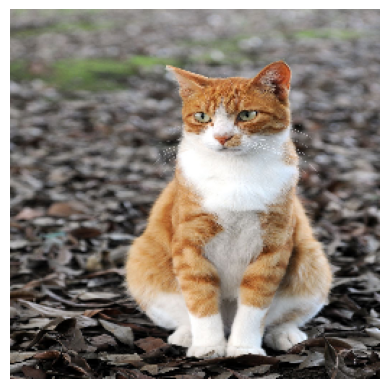

Model: MobileViT_v1-XXS, Predictions: 274
Model: MobileViT_v1-XS, Predictions: 282
Model: MobileViT_v1-S, Predictions: 282


In [ ]:
test_prediction(image_path=r"cat.jpg", model=keras_model_XXS, show=True)
test_prediction(image_path=r"cat.jpg", model=keras_model_XS)
test_prediction(image_path=r"cat.jpg", model=keras_model_S)

In [ ]:
!wget -qnc https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/1920px-Grosser_Panda.JPG -O pandas.jpg

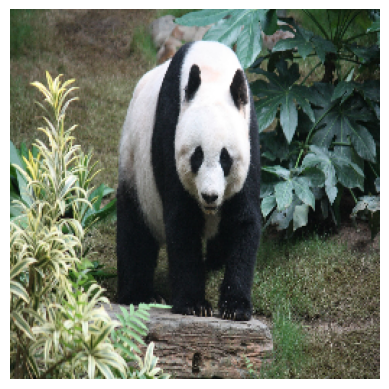

Model: MobileViT_v1-XXS, Predictions: 388
Model: MobileViT_v1-XS, Predictions: 388
Model: MobileViT_v1-S, Predictions: 388


In [ ]:
test_prediction(image_path=r"pandas.jpg", model=keras_model_XXS, show=True)
test_prediction(image_path=r"pandas.jpg", model=keras_model_XS)
test_prediction(image_path=r"pandas.jpg", model=keras_model_S)

# Bonus: Python package

In [ ]:
!pip install -U keras-vision

In [ ]:
from keras_vision.MobileViT_v1 import build_MobileViT_v1

In [ ]:
# build_MobileViT_v1(model_type="XXS", pretrained=True, include_top=False).summary()
# build_MobileViT_v1(model_type="XXS", pretrained=False, include_top=True, num_classes=1).summary()
# build_MobileViT_v1(model_type="XXS", pretrained=False, include_top=False).summary()
build_MobileViT_v1(model_type="XXS", pretrained=True, include_top=True, num_classes=1).summary()

Model: "MobileViT_v1-XXS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-1-Conv (ConvLayer)             │ (None, 128, 128, 16)        │             496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-1-IR2 (InvertedResidualBlock)  │ (None, 128, 128, 16)        │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-2-IR1 (InvertedResidualBlock)  │ (None, 64, 64, 24)          │           1,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-2-IR2 (InvertedResidualBlock)  │ (None, 64, 64, 24)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-2-IR3 (InvertedResidualBlock)  │ (None, 64, 64, 24)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-3-IR1 (InvertedResidualBlock)  │ (None, 32, 32, 48)          │           4,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileViTBlock-1                     │ (None, 32, 32, 48)          │         136,000 │
│ (MobileViT_v1_Block)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-4-IR1 (InvertedResidualBlock)  │ (None, 16, 16, 64)          │          12,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileViTBlock-2                     │ (None, 16, 16, 64)          │         330,080 │
│ (MobileViT_v1_Block)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block-5-IR1 (InvertedResidualBlock)  │ (None, 8, 8, 80)            │          20,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileViTBlock-3                     │ (None, 8, 8, 80)            │         413,664 │
│ (MobileViT_v1_Block)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ final_conv (ConvLayer)               │ (None, 8, 8, 320)           │          26,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 320)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_221 (Dense)                    │ (None, 1)                   │             321 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 955,457 (3.64 MB)

 Trainable params: 951,345 (3.63 MB)

 Non-trainable params: 4,112 (16.06 KB)